# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [127]:
#%pip install wandb

In [18]:
import subprocess
import wandb
from wandb.keras import WandbCallback

In [6]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [7]:
wandb.init(project='precursor_charge_prediction')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [ ]:
#%pip install seaborn

In [20]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

# Dataset batches + split

In [118]:
import re
# the dictionary
aa_syntax_dictionary = dict()
for index, i in enumerate(list('XACDEFGHIKLMNPQRSTVWY')): # added X for 0 value
    aa_syntax_dictionary[i] = index * 100
    if i != 'X': # ignore 0 value for X
        for count in range(0, 100):
            aa_syntax_dictionary[i + "[UNIMOD:" + str(count) + "]"] = index * 100 + count

def seq_translator(sequence, dictionary=aa_syntax_dictionary, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    if print_result:
        print(result)
    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (50 - len(result))

    return [dictionary[aa] for aa in result]


def one_hot_precursor(int_value, charges=[2,3,4]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [119]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=True))
print(one_hot_precursor(2))

['A', 'A', 'C[UNIMOD:4]', 'L', 'L', 'V', 'A', 'W']
[100, 100, 204, 1000, 1000, 1800, 100, 1900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0]


In [120]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [121]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [2, 3, 4] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df["modified_sequence_vector"] = df["modified_sequence"].apply(seq_translator)
    df["precursor_charge_vector"] = df["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    if counter > 1:
        break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [122]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [123]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity,modified_sequence_vector,precursor_charge_vector
0,LPGSLETYVEQEQGENANDR,2,29525630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000,...","[1, 0, 0]"
1,HGSLQEYLQNDTGSK,2,13188580.0,"[700, 600, 1600, 1000, 1400, 400, 2000, 1000, ...","[1, 0, 0]"
2,VEEEEEINSELTAR,2,20663460.0,"[1800, 400, 400, 400, 400, 400, 800, 1200, 160...","[1, 0, 0]"
3,LPGSLETYVEQEQGENANDR,2,19884630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000,...","[1, 0, 0]"
4,NSSTAEINETTTSSTDFLAR,2,12804420.0,"[1200, 1600, 1600, 1700, 100, 400, 800, 1200, ...","[1, 0, 0]"


In [124]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
Name: precursor_charge, dtype: int64

# Multi-label-dictionary

In [125]:
def multi_label_one_hot_precursor(charge_list, charges_included=[2,3,4]):

    one_hot_encoded = [1 if label in charge_list else 0 for label in charges_included]

    return one_hot_encoded

In [18]:
# Grouping by "modified_sequence" and aggregating precursor_charge into a list
grouped_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge"].agg(list).reset_index()
grouped_df

,modified_sequence,precursor_charge
0,AAAASAAEAGIATTGTEGER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, ..."
1,AAAC[UNIMOD:4]FFEQPPR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,AAADFATHGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,AAADLMAYC[UNIMOD:4]EAHAK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
4,AAADSDPNLDPLMNPHIR,"[3, 3, 3, 3]"
...,...,...
70310,YYVYWYQQLPGTTPK,"[2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
70311,YYYENSDQPIDLTK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
70312,YYYGHYLDDYHTK,"[2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, ..."
70313,YYYSDNFFDGQR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."


In [13]:
multi_label_df = grouped_df.copy()
multi_label_df["precursor_charge"] = grouped_df["precursor_charge"].apply(multi_label_one_hot_precursor)
multi_label_df["modified_sequence_vector"] = grouped_df["modified_sequence"].apply(seq_translator)


In [14]:
multi_label_df

,modified_sequence,precursor_charge,modified_sequence_vector
0,AAAASAAEAGIATTGTEGER,"[1, 1, 0]","[100, 100, 100, 100, 1600, 100, 100, 400, 100,..."
1,AAAC[UNIMOD:4]FFEQPPR,"[1, 0, 0]","[100, 100, 100, 204, 500, 500, 400, 1400, 1300..."
2,AAADFATHGK,"[1, 0, 0]","[100, 100, 100, 300, 500, 100, 1700, 700, 600,..."
3,AAADLMAYC[UNIMOD:4]EAHAK,"[1, 0, 0]","[100, 100, 100, 300, 1000, 1100, 100, 2000, 20..."
4,AAADSDPNLDPLMNPHIR,"[0, 1, 0]","[100, 100, 100, 300, 1600, 300, 1300, 1200, 10..."
...,...,...,...
70910,YYVYWYQQLPGTTPK,"[1, 1, 0]","[2000, 2000, 1800, 2000, 1900, 2000, 1400, 140..."
70911,YYYENSDQPIDLTK,"[1, 0, 0]","[2000, 2000, 2000, 400, 1200, 1600, 300, 1400,..."
70912,YYYGHYLDDYHTK,"[1, 1, 1]","[2000, 2000, 2000, 600, 700, 2000, 1000, 300, ..."
70913,YYYSDNFFDGQR,"[1, 0, 0]","[2000, 2000, 2000, 1600, 300, 1200, 500, 500, ..."


### import preprocessed df's

In [126]:
# Make validation data
sample_df = batches_parquet[file_list[0]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [127]:
split_to_columns = True # TODO SET BOOL

In [128]:
if split_to_columns:
    sample_df[list(range(0, 50))] = pd.DataFrame(sample_df["modified_sequence_vector"].tolist(), index= sample_df.index)
    sample_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [129]:
sample_df.head(4)

,precursor_charge,precursor_intensity,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,2,29525630.0,1000,1300,600,1600,1000,400,1700,2000,...,0,0,0,0,0,0,0,0,0,0
1,2,13188580.0,700,600,1600,1000,1400,400,2000,1000,...,0,0,0,0,0,0,0,0,0,0
2,2,20663460.0,1800,400,400,400,400,400,800,1200,...,0,0,0,0,0,0,0,0,0,0
3,2,19884630.0,1000,1300,600,1600,1000,400,1700,2000,...,0,0,0,0,0,0,0,0,0,0


In [130]:
main_ds = tf.convert_to_tensor(sample_df)

In [131]:
main_ds

<tf.Tensor: shape=(5970269, 52), dtype=float64, numpy=
array([[2.000000e+00, 2.952563e+07, 1.000000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.000000e+00, 1.318858e+07, 7.000000e+02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.000000e+00, 2.066346e+07, 1.800000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [3.000000e+00, 1.147428e+05, 4.000000e+02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.000000e+00, 1.147428e+05, 4.000000e+02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.000000e+00, 2.021142e+05, 2.000000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])>

In [132]:
from sklearn.model_selection import train_test_split

target = main_ds[:, 0]
features = main_ds[:, 1:]

# Perform the split
train_ds, val_ds, train_ds_labels, val_ds_labels = train_test_split(np.array(features), np.array(target), test_size=0.2, random_state=42)


In [353]:
len(train_ds)+len(val_ds)

5970269

In [354]:
len(train_ds)

4776215

In [17]:
# # Split the data into train, validation, and test sets
# X_2 = np.array(sample_df['modified_sequence_vector'].tolist())
# y_2 = np.array(sample_df['precursor_charge'])
# max_len = max(sample_df.loc[:, 'modified_sequence_vector'].apply(len))  # Find the maximum length
#
#
# # Create an instance of StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#
# # Perform the split
# train_val_indices, test_indices = next(sss.split(X_2, y_2))
# X_2_train_val, X_2_test = X_2[train_val_indices], X_2[test_indices]
# y_2_train_val, y_2_test = y_2[train_val_indices], y_2[test_indices]
#
# # Create another instance of StratifiedShuffleSplit for train-validation split
# sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#
# # Perform the train-validation split
# train_indices, val_indices = next(sss_train_val.split(X_2_train_val, y_2_train_val))
# X_2_train, X_2_val = X_2_train_val[train_indices], X_2_train_val[val_indices]
# y_2_train, y_2_val = y_2_train_val[train_indices], y_2_train_val[val_indices]
#
# num_classes = 8  # Number of precursor charge classes (1 to 7, plus an extra class for 'None' charge)
# y_2_train_encoded = tf.keras.utils.to_categorical(y_2_train, num_classes)
# y_2_val_encoded = tf.keras.utils.to_categorical(y_2_val, num_classes)
# y_2_test_encoded = tf.keras.utils.to_categorical(y_2_train, num_classes)

### KerasTuner

In [112]:
import datetime
logdir = os.path.join("logs_kerastuner", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_kerastuner = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [150]:
#%pip install keras-tuner
import keras_tuner
from tensorflow import keras

def build_model(hp):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_len, output_dim=20, input_length=X_2.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=hp.Int('dense_1_units', min_value=16, max_value=256, step=8),
                          activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    #hp.Choice('unknown', values=[1, 10])
    ])
    # Compile the model
    learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.001, sampling="log"),
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True,
    executions_per_trial=3,
    directory='output_tuner',)

tuner.search(train_ds, epochs=30, validation_data=val_ds, callbacks=[tensorboard_callback_kerastuner, WandbCallback()])

best_model = tuner.get_best_models()[0]

IndexError: tuple index out of range

In [ ]:
from tensorboard import program

tracking_address = "logs_kerastuner" # the path of your log file.

if __name__ == "__main__":
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', tracking_address])
    url = tb.launch()
    print(f"Tensorflow listening on {url}")

### Model

In [133]:
train_ds_labels

array([3., 2., 2., ..., 2., 2., 2.])

In [134]:
train_ds_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in train_ds_labels])

In [135]:
val_ds_labels = np.array([one_hot_precursor(i, charges=charge_ranges) for i in val_ds_labels])

In [136]:
train_ds_labels

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [233]:
# # hot encoding
# train_ds_labels = tf.convert_to_tensor([one_hot_precursor(i) for i in train_ds_labels])
# val_ds_labels = tf.convert_to_tensor([one_hot_precursor(i) for i in val_ds_labels])

In [137]:
train_ds.shape

(4776215, 51)

In [138]:
train_ds

array([[1.796888e+07, 1.800000e+03, 1.300000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.124313e+05, 4.000000e+02, 1.800000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [3.148090e+06, 1.000000e+03, 7.000000e+02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.016920e+07, 1.800000e+03, 1.300000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [4.015268e+07, 1.800000e+03, 2.040000e+02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.218693e+06, 1.600000e+03, 2.000000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [200]:
# Define model
model_cce = tf.keras.models.Sequential([
    #tf.keras.layers.Embedding(input_dim=num_classes, output_dim=8, input_length=train_ds.shape[1]),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(128, activation='relu', input_shape=(train_ds.shape[1],)),
    #tf.keras.layers.Dense(64, activation='relu'), #kernel_constraint=MaxNorm(3)
    #tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_cce.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [201]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [202]:
# Train the model
# X_train, X_test, y_train, y_test
history_cce = model_cce.fit(train_ds, train_ds_labels, epochs=30, batch_size=256, validation_data=(val_ds, val_ds_labels), callbacks=[WandbCallback()])

Epoch 1/30
18588/18658 [============================>.] - ETA: 0s - loss: 733106.0000 - accuracy: 0.6055


KeyboardInterrupt



In [193]:
model_cce.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, None)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               6656      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 17,091
Trainable params: 17,091
Non-trainable params: 0
_________________________________________________________________


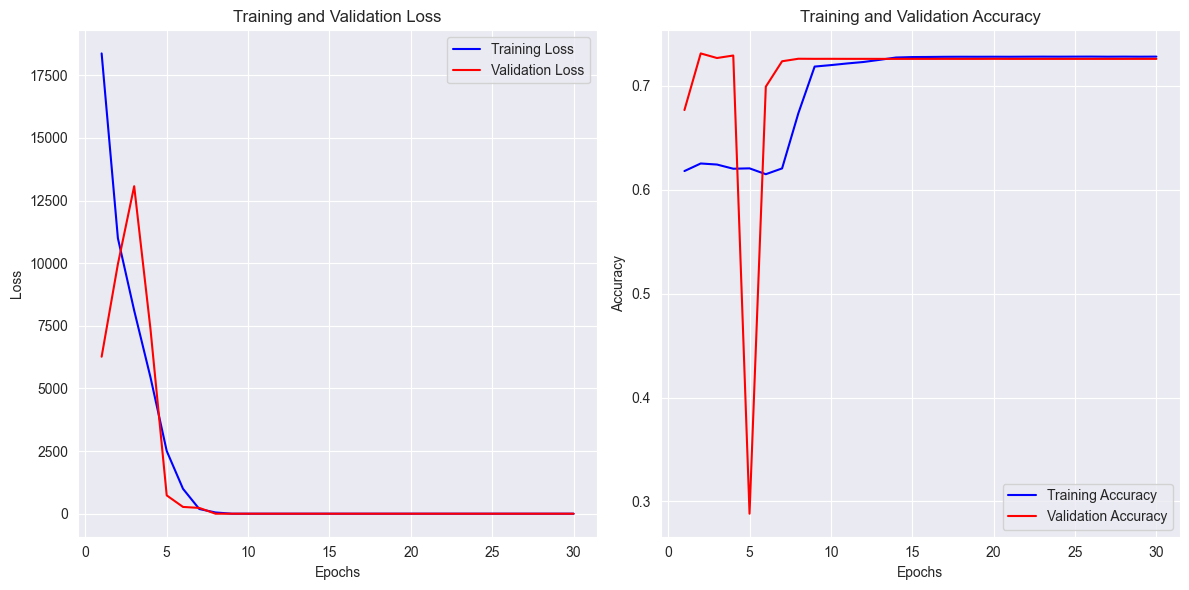

In [146]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_cce.history['loss']
val_loss = history_cce.history['val_loss']
accuracy = history_cce.history['accuracy']
val_accuracy = history_cce.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [147]:
model_cce.save('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [148]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
Name: precursor_charge, dtype: int64

In [84]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

In [149]:
batches_parquet.keys()

dict_keys(['data/Thermo_SRM_Pool_meta_data.parquet', 'data/TUM_aspn_meta_data.parquet'])

In [153]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [151]:
inference_df.head(4)

,precursor_charge,modified_sequence_vector,precursor_intensity
0,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7552496.0
1,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7674974.0
2,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
3,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",1224600.0


In [88]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

[42]

In [89]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [107]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

[]

In [98]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

[]

In [102]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

[]

In [154]:
inference_df

,precursor_charge,modified_sequence_vector,precursor_intensity
0,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7552496.0
1,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7674974.0
2,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
3,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",1224600.0
4,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
...,...,...,...
2586142,3,"[300, 1800, 1000, 1600, 1200, 204, 400, 500, 1...",10454540.0
2586148,3,"[300, 800, 1500, 800, 900, 400, 400, 400, 1300...",5171662.0
2586154,4,"[300, 400, 1400, 1800, 100, 1000, 900, 900, 90...",37526080.0
2586155,3,"[300, 1300, 300, 1300, 1400, 1300, 1500, 2000,...",8926203.0


In [155]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

In [156]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [157]:
inference_df.head(4)

,precursor_charge,precursor_intensity,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,2,7552496.0,300,1600,1800,600,400,800,1700,900,...,0,0,0,0,0,0,0,0,0,0
1,2,7674974.0,300,1600,1800,600,400,800,1700,900,...,0,0,0,0,0,0,0,0,0,0
2,2,3298128.0,300,1600,1800,600,400,800,1700,900,...,0,0,0,0,0,0,0,0,0,0
3,2,1224600.0,300,1600,1800,600,400,800,1700,900,...,0,0,0,0,0,0,0,0,0,0


In [166]:
inference_ds = tf.convert_to_tensor(inference_df)

In [167]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [168]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [170]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

9412/9412 [==============================] - 8s 845us/step - loss: 0.9933 - accuracy: 0.5819
test loss, test acc: [0.9932876229286194, 0.5818654894828796]


## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [192]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

ValueError: Found input variables with inconsistent numbers of samples: [4776215, 2409349]

In [184]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


[1 0 0]
tf.Tensor(
[7.552496e+06 3.000000e+02 1.600000e+03 1.800000e+03 6.000000e+02
 4.000000e+02 8.000000e+02 1.700000e+03 9.000000e+02 4.000000e+02
 3.000000e+02 1.000000e+03 8.000000e+02 1.400000e+03 9.000000e+02
 1.600000e+03 1.000000e+03 6.000000e+02 1.700000e+03 2.040000e+02
 1.400000e+03 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00], shape=(51,), dtype=float64)


ValueError: in user code:

    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense_3" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float64)
      • training=False
      • mask=None


Accuracy/ Sens/ Spec

In [185]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

NameError: name 'true_labels' is not defined

MCC

In [ ]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

Direct eval:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [ ]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')